In [1]:
# import tensorflow as tf
# print(tf.config.list_physical_devices('GPU'))
import pandas as pd
import numpy as np
import wfdb
from pathlib import Path
import ast
from wfdb import processing
from scipy.fftpack import fft, ifft 
import pywt as pw
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import Preprocessing
from importlib import reload
import transformers
import random
from transformers import Transformers
import scipy.signal as signal

loading the signals

In [2]:
reload(Preprocessing)

load = Preprocessing.preprocess()
x_train, y_train, x_test, y_test = load.loadData()

origin_signals = np.zeros((19601, 12, 1000))
origin_test_signals = np.zeros((2198, 12, 1000))

for sig in range(x_train.shape[0]):
    for lead in range(x_train.shape[2]):
        
        origin_signals[sig, lead, :] = x_train[sig].T[lead][:] 

for sig in range(x_test.shape[0]):
    for lead in range(x_test.shape[2]):
        
        origin_test_signals[sig, lead, :] = x_test[sig].T[lead][:] 

# np.save('highpass_filtered.npy', filtered_data)
# loaded_highpassedfiltered_signal = np.load('highpass_filtered.npy')
loaded_bandpassedfiltered_signal = np.load('bandpass_filtered.npy')

In [3]:
loaded_bandpassedfiltered_signal.shape

(19601, 12, 1000)

Freq Analysis

In [ ]:
reload(transformers)
T = Transformers()
T.FFT(origin_signals[0][0][:])

Noise-removal

In [3]:
reload(Preprocessing)

""" all the filtering techniques are applied to the train signals """
filter = Preprocessing.preprocess()

baseline_removed_signals, bandpassfiltered_signals, smoothedfiltered_signals = np.zeros((19601, 12, 1000)), np.zeros((19601, 12, 1000)), np.zeros((19601, 12, 1000))



# for sig in range(origin_signals.shape[0]):
#     for lead in range(origin_signals.shape[1]):
        

#         """ baseline removal """
#         baseline_removed_signals[sig][lead] = filter.highpassfilter(origin_signals[sig][lead][:], 100, 4, 0.5)

#         """ smoothing the variations """
#         bandpassfiltered_signals[sig][lead] = filter.bandpassfilter(baseline_removed_signals[sig][lead][:], 100, 4, 0.5, 25)

for sig in range(origin_signals.shape[0]):
    for lead in range(origin_signals.shape[1]):

        smoothedfiltered_signals[sig][lead] = filter.movingaveragefilter(origin_signals[sig][lead][:])
        

In [ ]:

for sig in range(origin_signals.shape[0]):
    for lead in range(origin_signals.shape[1]):
        

        """ baseline removal """
        baseline_removed_signals[sig][lead] = filter.highpassfilter(smoothedfiltered_signals[sig][lead][:], 100, 4, 0.5)

        """ smoothing the variations """
        bandpassfiltered_signals[sig][lead] = filter.bandpassfilter(baseline_removed_signals[sig][lead][:], 100, 4, 0.5, 25)

np.save('bandpass_filtered.npy', bandpassfiltered_signals)


QRS Detection

In [ ]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

def detect_r_peaks(ecg_signal, sampling_rate, min_distance, threshold):
    # Bandpass filter to remove noise and isolate QRS complex
    lowcut = 0.5  # Low cutoff frequency in Hz
    highcut = 15.0  # High cutoff frequency in Hz
    nyquist_freq = 0.5 * sampling_rate
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = signal.butter(1, [low, high], btype='band')
    filtered_ecg = signal.filtfilt(b, a, ecg_signal)
    
    # Find R-peaks using peak detection with a threshold
    r_peaks, _ = signal.find_peaks(filtered_ecg, distance=min_distance, height=threshold)
    
    return r_peaks

random_numbers = [random.randint(1,2100) for x in range(10)]
sampling_rate = 100  # Replace with the actual sampling rate of your ECG signal
min_distance = 30
threshold = 0.3 # Adjust the threshold as needed

for i in random_numbers:

    # Example usage
    ecg_signal = loaded_highpassedfiltered_signal[i][0][:]
    r_peaks = detect_r_peaks(ecg_signal, sampling_rate, min_distance, threshold)

    # Plot the ECG signal and detected R-peaks
    time = np.arange(len(ecg_signal)) / sampling_rate
    plt.figure(figsize=(20,4))
    plt.plot(time, ecg_signal, label='ECG Signal')
    plt.scatter(time[r_peaks], ecg_signal[r_peaks], c='r', marker='o', label='R-peaks')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('ECG Signal with Detected R-peaks')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def detect_r_peaks(ecg_signal, sampling_rate, min_distance, threshold):
    # Bandpass filter to remove noise and isolate QRS complex
    lowcut = 0.5  # Low cutoff frequency in Hz
    highcut = 15.0  # High cutoff frequency in Hz
    nyquist_freq = 0.5 * sampling_rate
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = signal.butter(1, [low, high], btype='band')
    filtered_ecg = signal.filtfilt(b, a, ecg_signal)
    
    # Differentiation to accentuate R-peaks
    diff_ecg = np.diff(filtered_ecg)
    
    # Squaring to emphasize the QRS complex
    squared_ecg = diff_ecg**2
    
    # Moving window integration to smooth and sum the squared values
    window_size = int(0.15 * sampling_rate)
    integrated_ecg = np.convolve(squared_ecg, np.ones(window_size), mode='valid')
    
    # Pad the integrated_ecg array to match the size of filtered_ecg
    pad_width = len(filtered_ecg) - len(integrated_ecg)
    integrated_ecg = np.pad(integrated_ecg, (0, pad_width), mode='constant')
    
    # Find R-peaks using adaptive thresholding
    peak_threshold = 0.5 * np.max(integrated_ecg)
    r_peaks = np.where((integrated_ecg > peak_threshold) & (filtered_ecg > threshold))[0] + (window_size // 2)
    
    # Remove peaks that are too close to each other
    valid_r_peaks = []
    last_peak = min_distance - 1
    for peak in r_peaks:
        if peak - last_peak > min_distance:
            valid_r_peaks.append(peak)
            last_peak = peak
    
    return valid_r_peaks
    
    
# Example usage
ecg_signal = loaded_highpassedfiltered_signal[200][0][:]
sampling_rate = 100
min_distance = 5
threshold = 0.4  # Specify the desired threshold value
num_peaks = 11
window_size = int(10 * sampling_rate)
overlap = int(1 * sampling_rate)
r_peaks = []

# Iterate over sliding windows to detect R-peaks
start = 0
while start + window_size <= len(ecg_signal):
    window_ecg = ecg_signal[start:start + window_size]
    window_r_peaks = detect_r_peaks(window_ecg, sampling_rate, min_distance, threshold)
    
    if len(r_peaks) + len(window_r_peaks) >= num_peaks:
        remaining_peaks = num_peaks - len(r_peaks)
        r_peaks.extend(window_r_peaks[:remaining_peaks])
        break
    else:
        r_peaks.extend(window_r_peaks)
    
    start += window_size - overlap

# Plot the ECG signal and detected R-peaks
time = np.arange(len(ecg_signal)) / sampling_rate
plt.figure()
plt.plot(time, ecg_signal, label='ECG Signal')
plt.scatter(time[r_peaks], ecg_signal[r_peaks], c='r', marker='o', label='R-peaks')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('ECG Signal with Detected R-peaks')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

def detect_r_peaks(ecg_signal, sampling_rate, min_distance_sec, threshold):
    # Bandpass filter to remove noise and isolate QRS complex
    lowcut = 0.5  # Low cutoff frequency in Hz
    highcut = 15.0  # High cutoff frequency in Hz
    nyquist_freq = 0.5 * sampling_rate
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = signal.butter(1, [low, high], btype='band')
    filtered_ecg = signal.filtfilt(b, a, ecg_signal)
    
    # Calculate minimum distance in samples
    min_distance_samples = int(min_distance_sec * sampling_rate)
    
    # Find R-peaks using peak detection with a threshold and minimum distance
    r_peaks, _ = signal.find_peaks(filtered_ecg, distance=min_distance_samples, height=threshold)
    
    return r_peaks


# Example usage
ecg_signal = loaded_highpassedfiltered_signal[0][0][:]
sampling_rate = 100  # Replace with the actual sampling rate of your ECG signal
min_distance_sec = 0.2  # Minimum distance between R-peaks in seconds
threshold = 0.4  # Adjust the threshold as needed

r_peaks = detect_r_peaks(ecg_signal, sampling_rate, min_distance_sec, threshold)

# Plot the ECG signal and detected R-peaks
time = np.arange(len(ecg_signal)) / sampling_rate
plt.figure()
plt.plot(time, ecg_signal, label='ECG Signal')
plt.scatter(time[r_peaks], ecg_signal[r_peaks], c='r', marker='o', label='R-peaks')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('ECG Signal with Detected R-peaks')
plt.legend()
plt.grid(True)
plt.show()


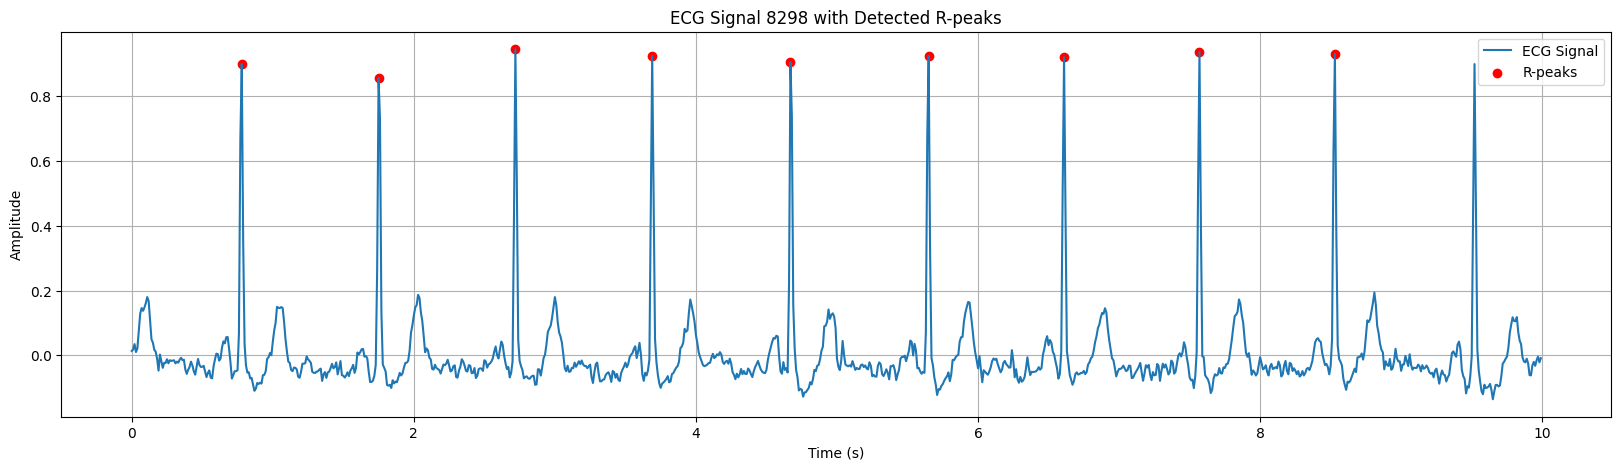

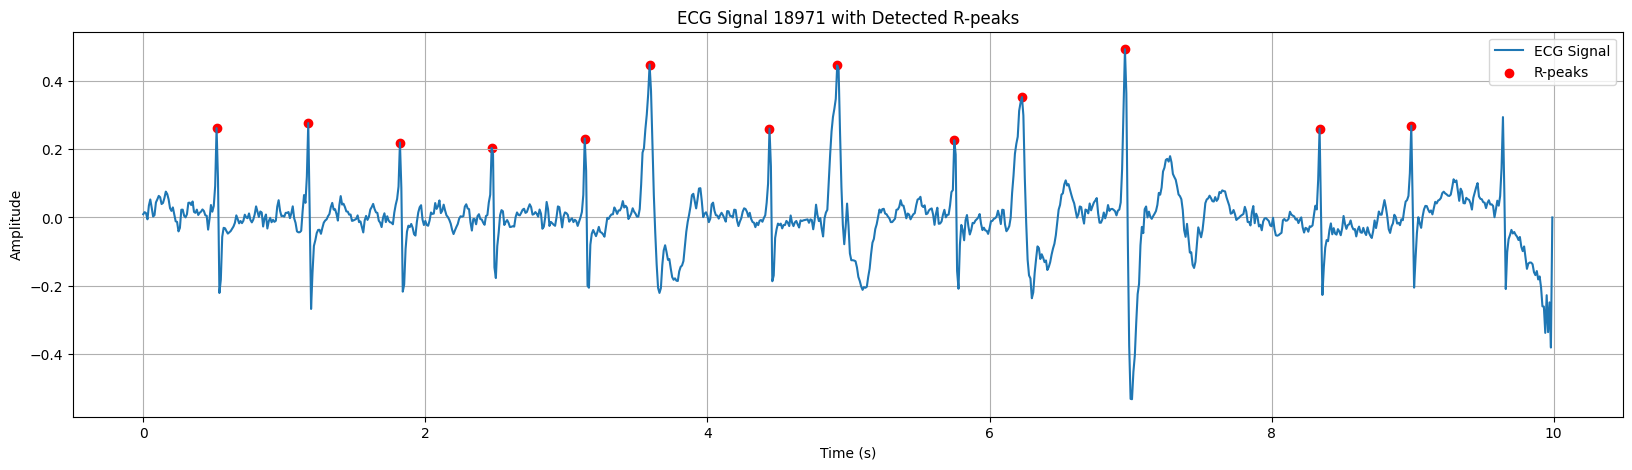

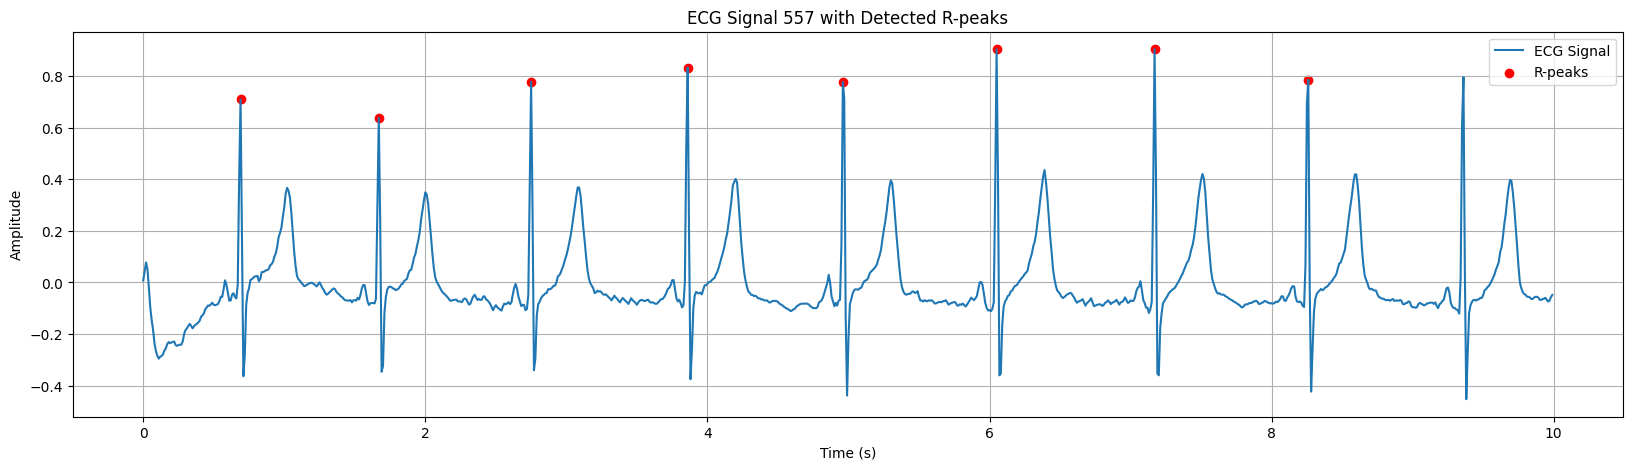

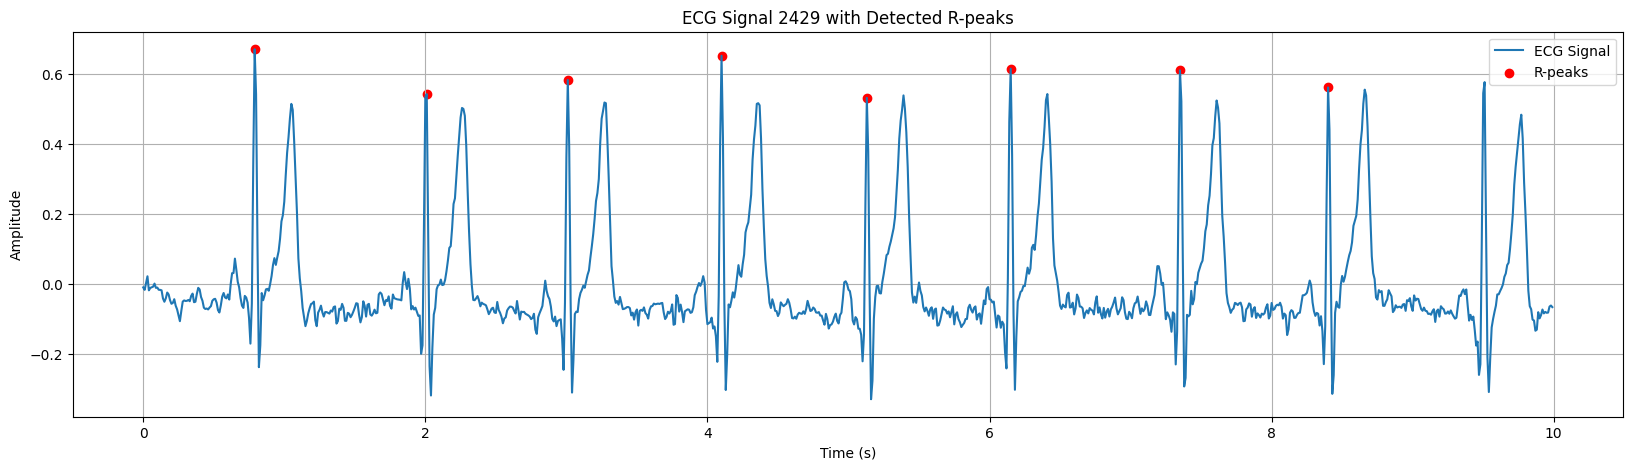

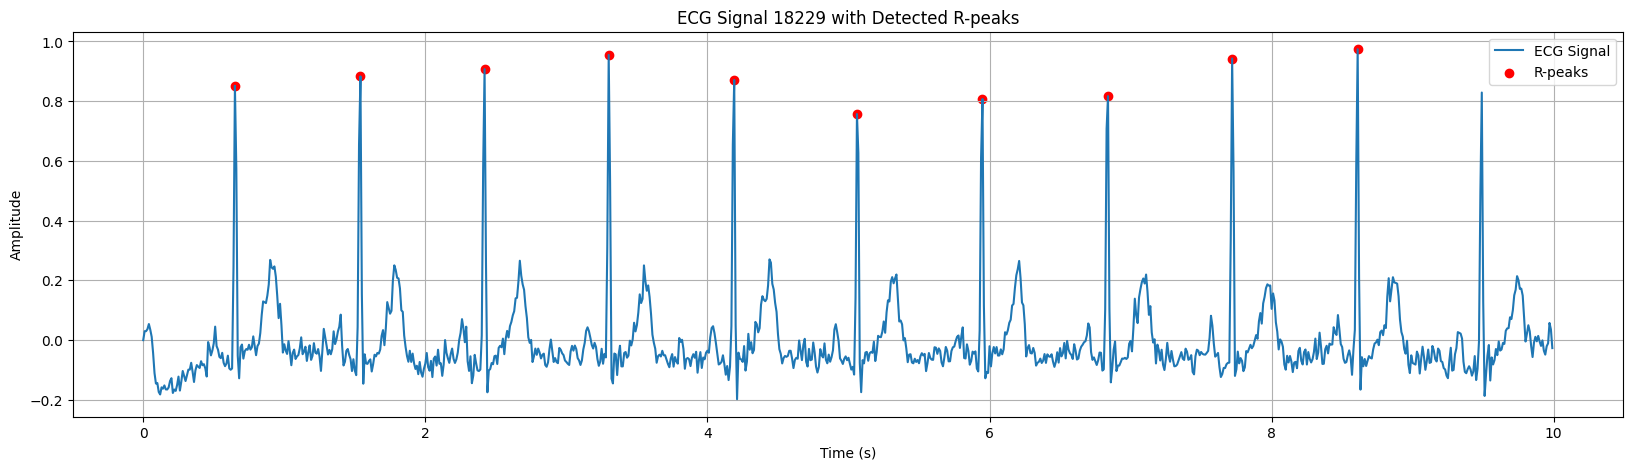

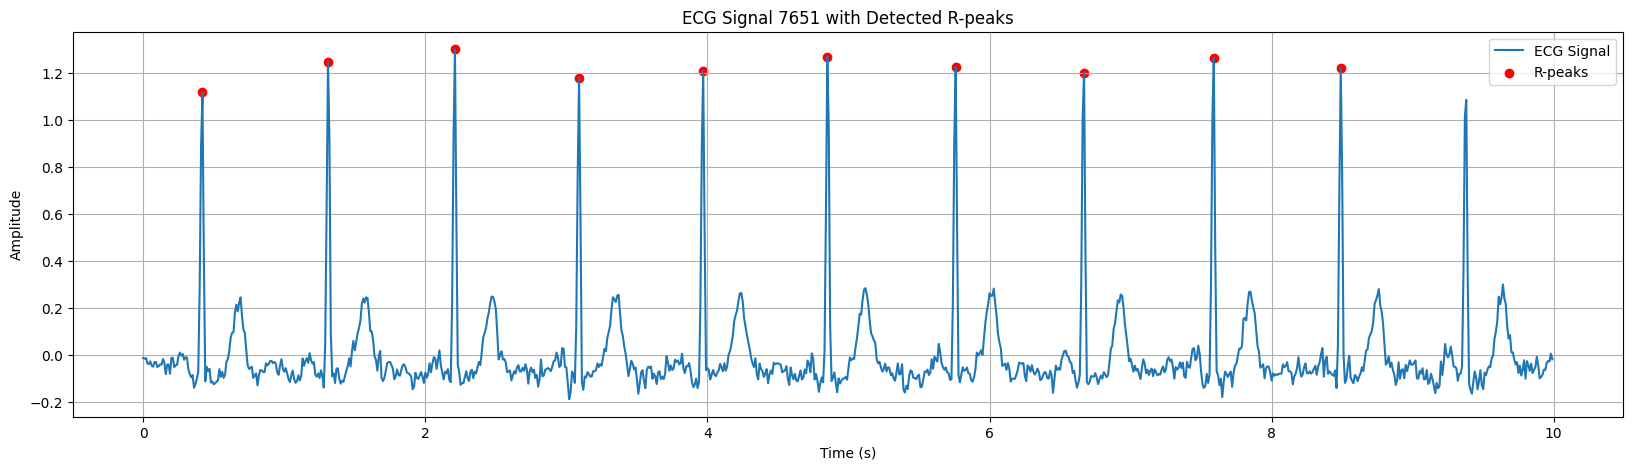

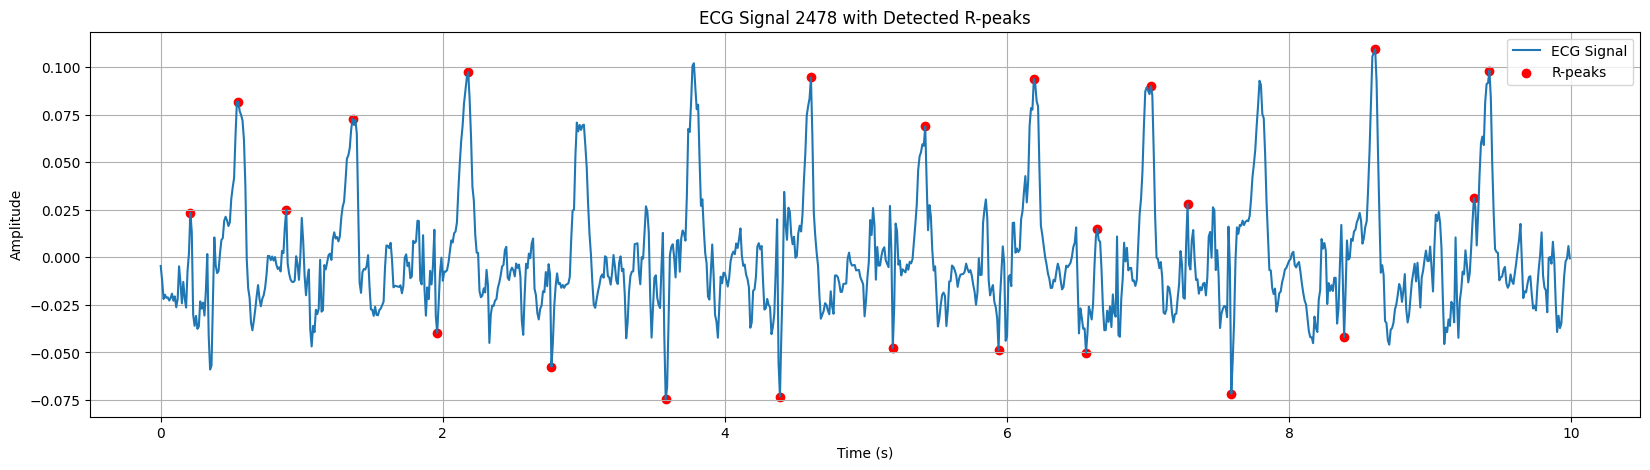

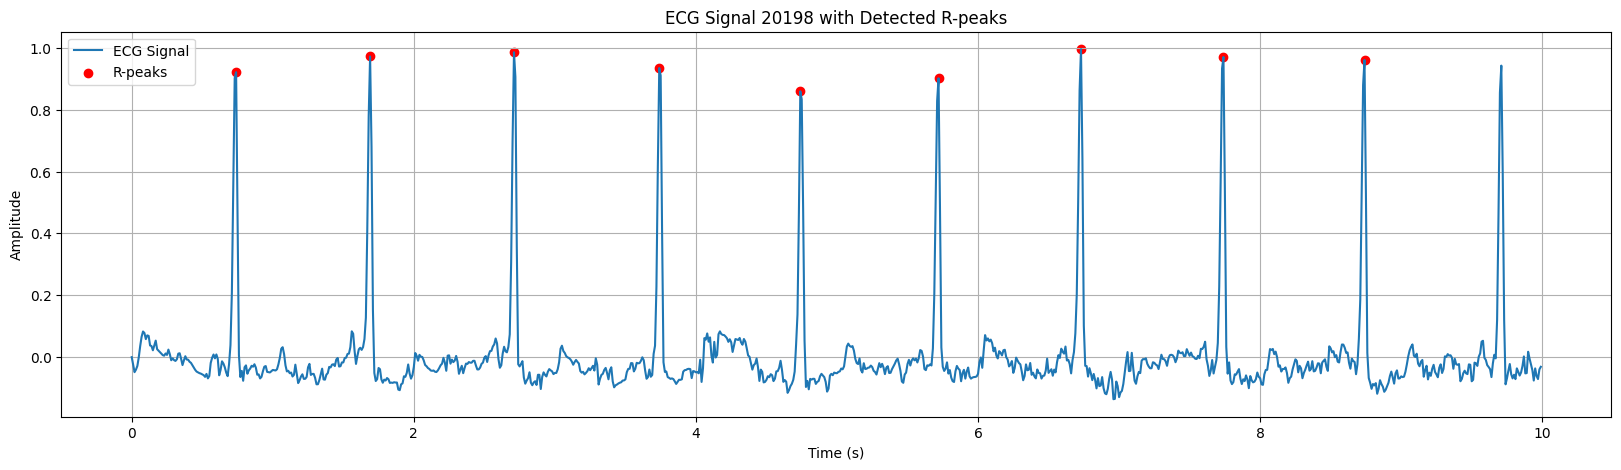

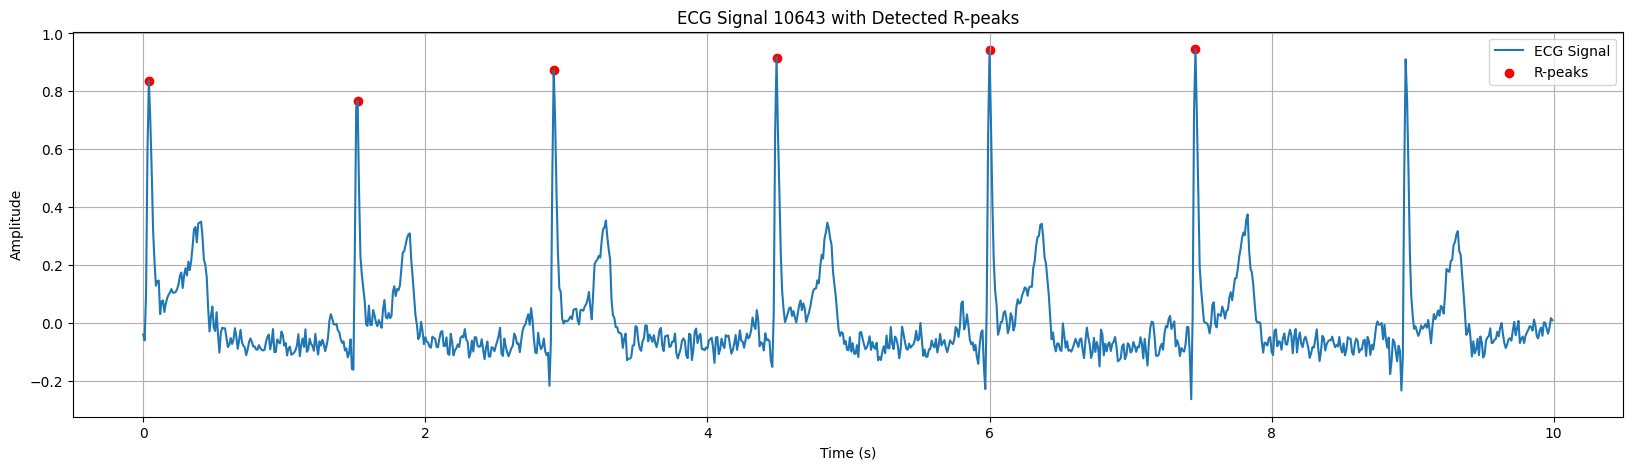

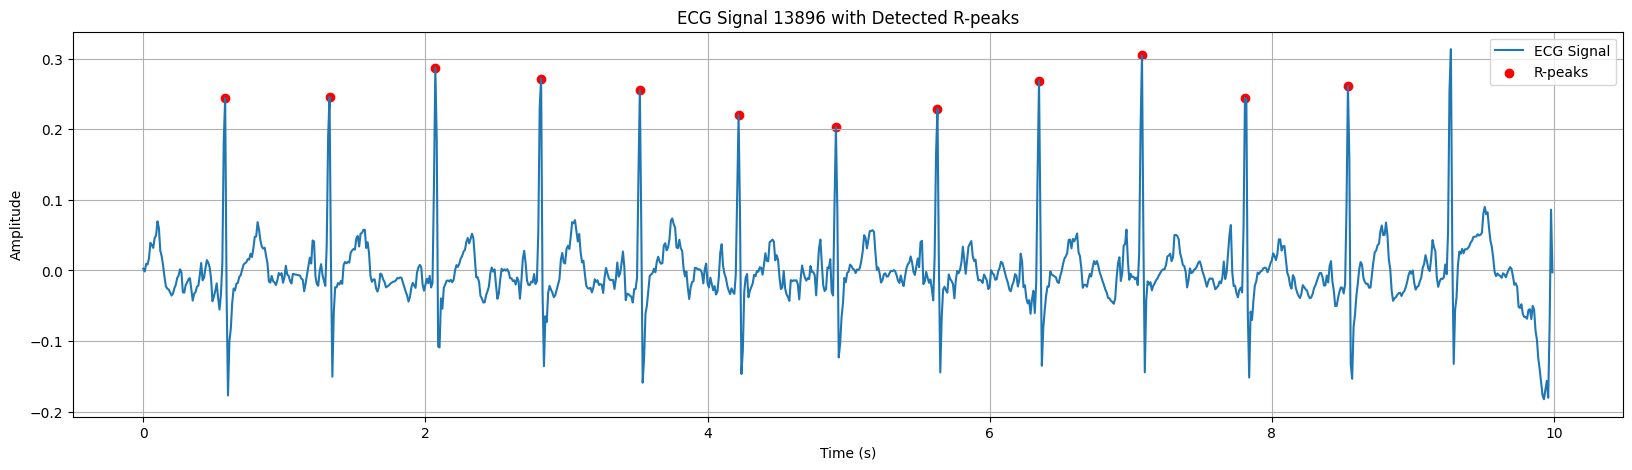

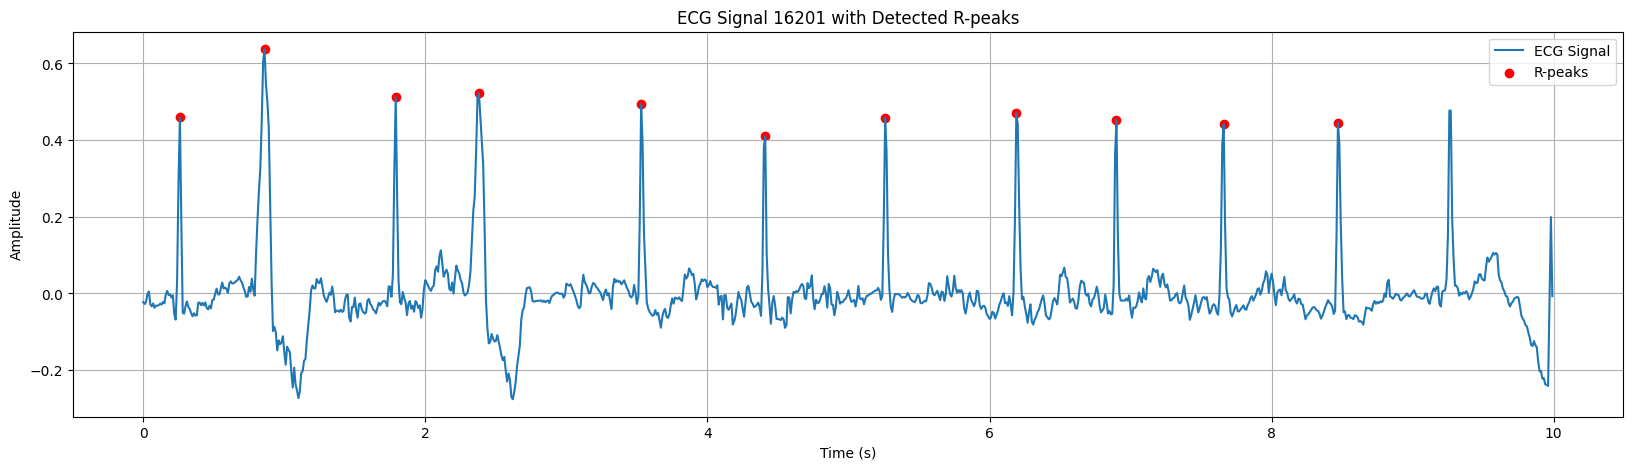

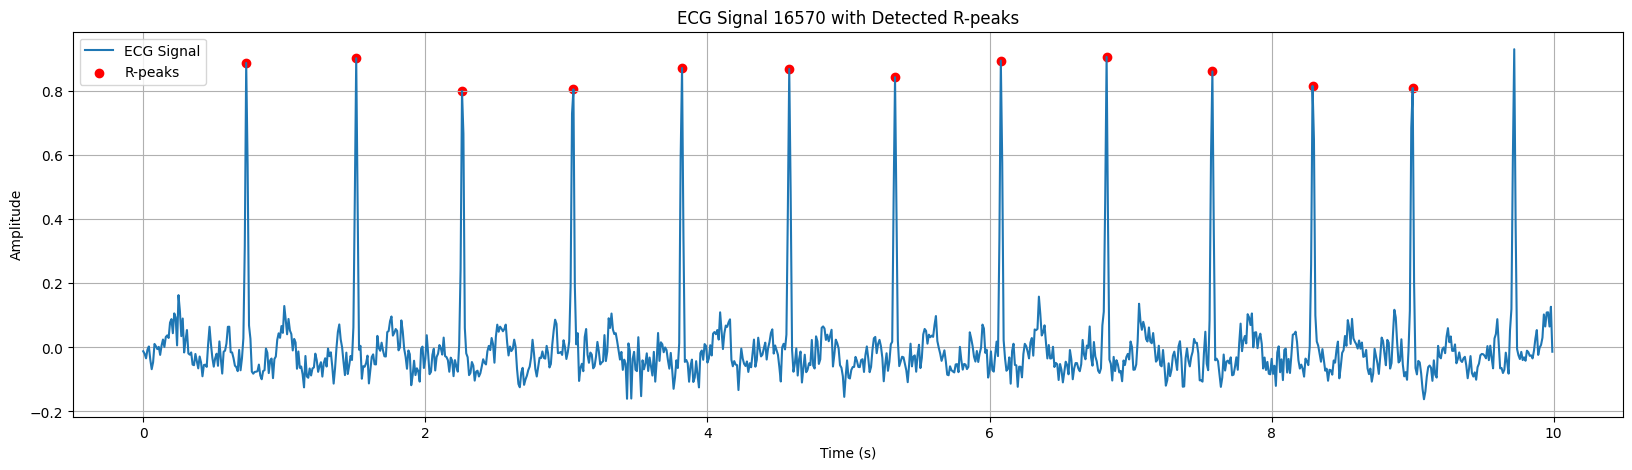

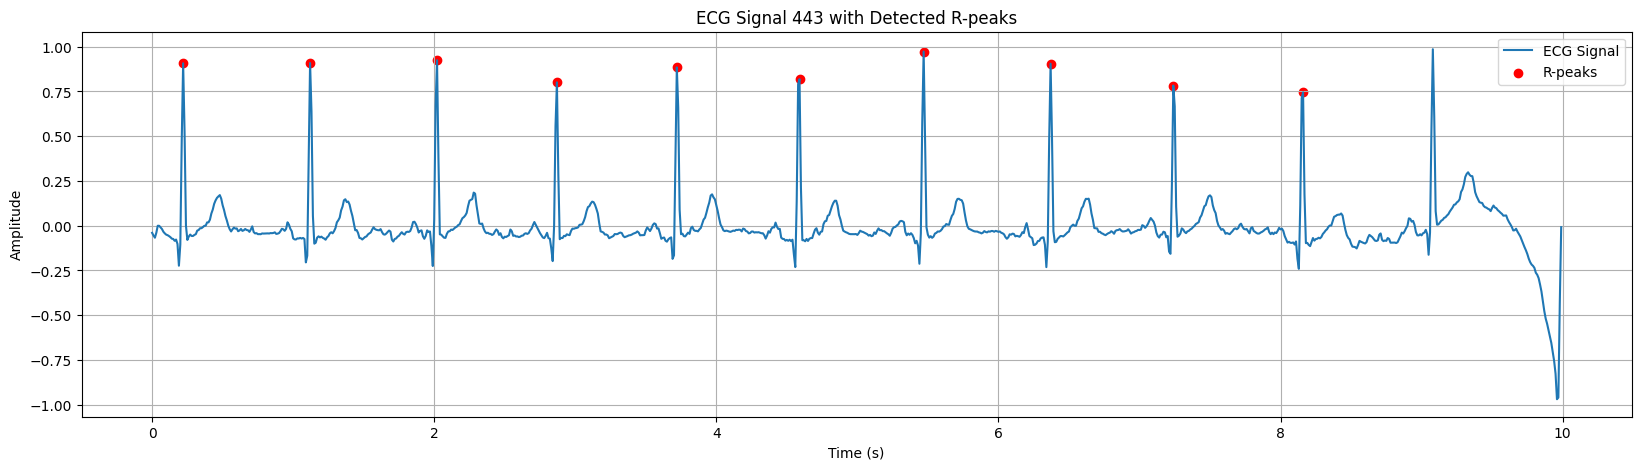

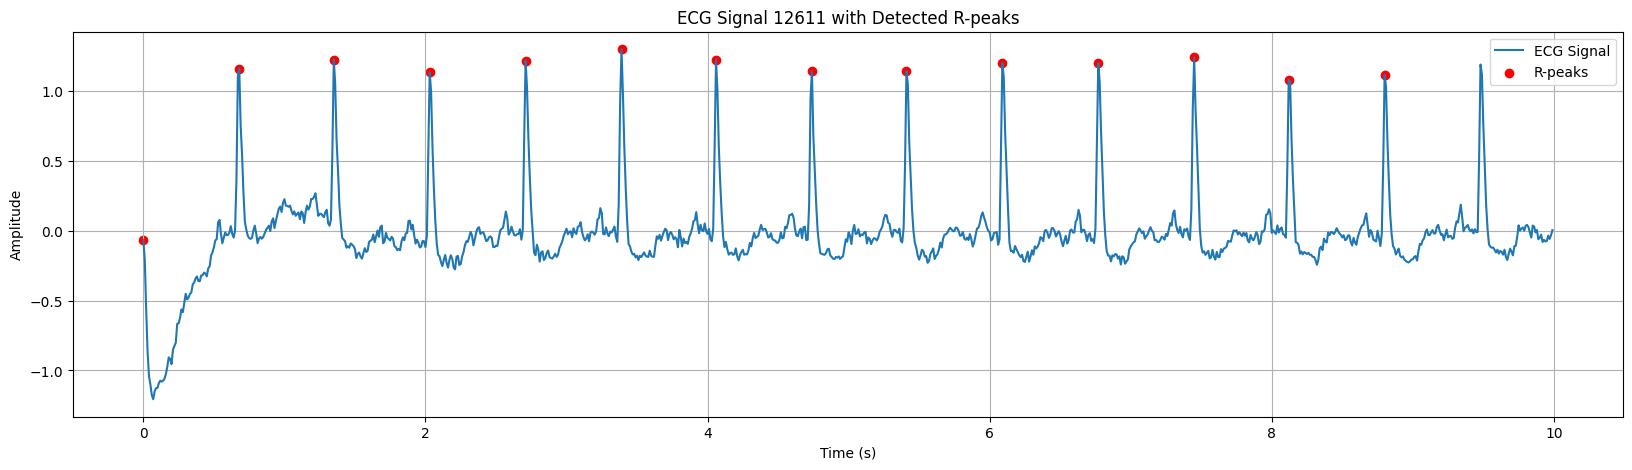

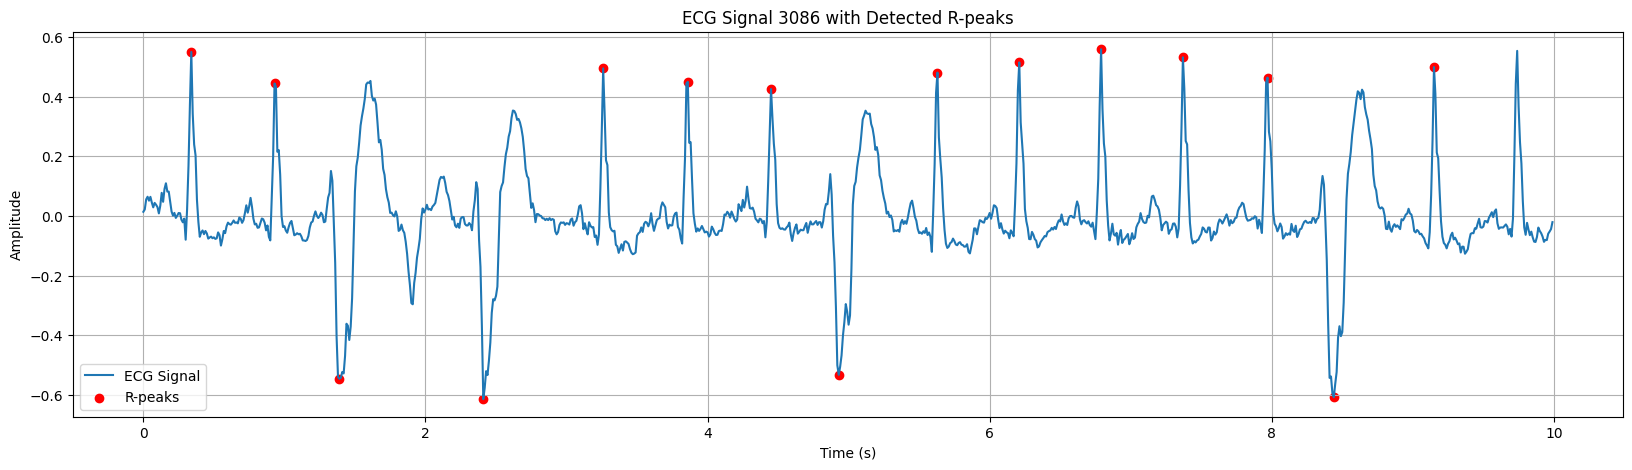

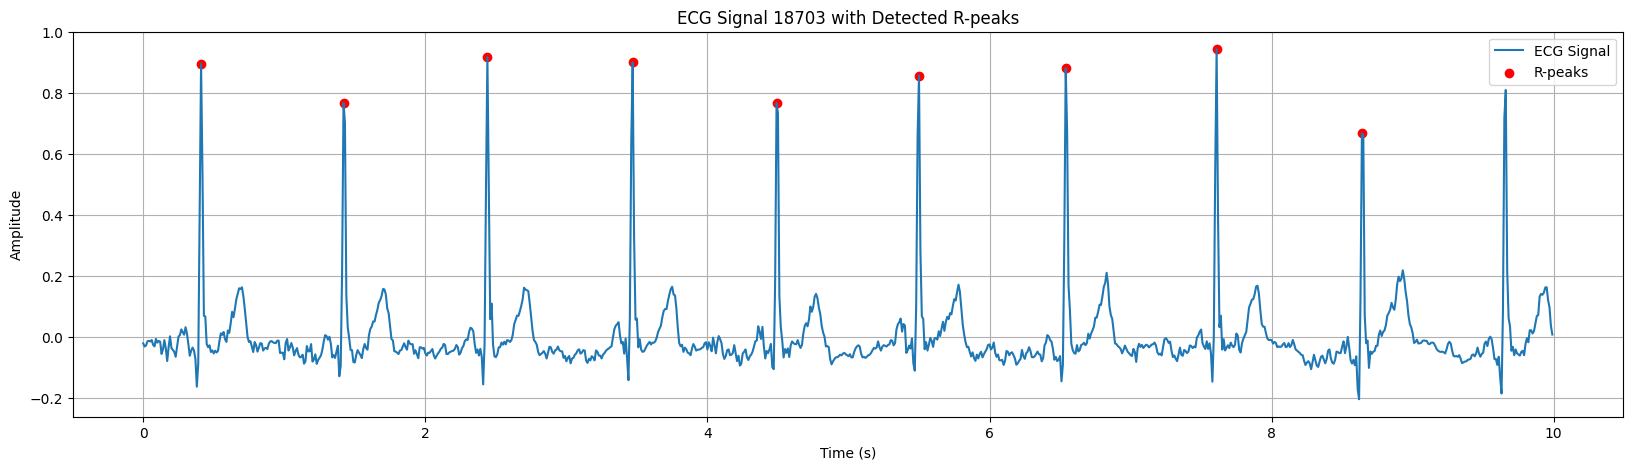

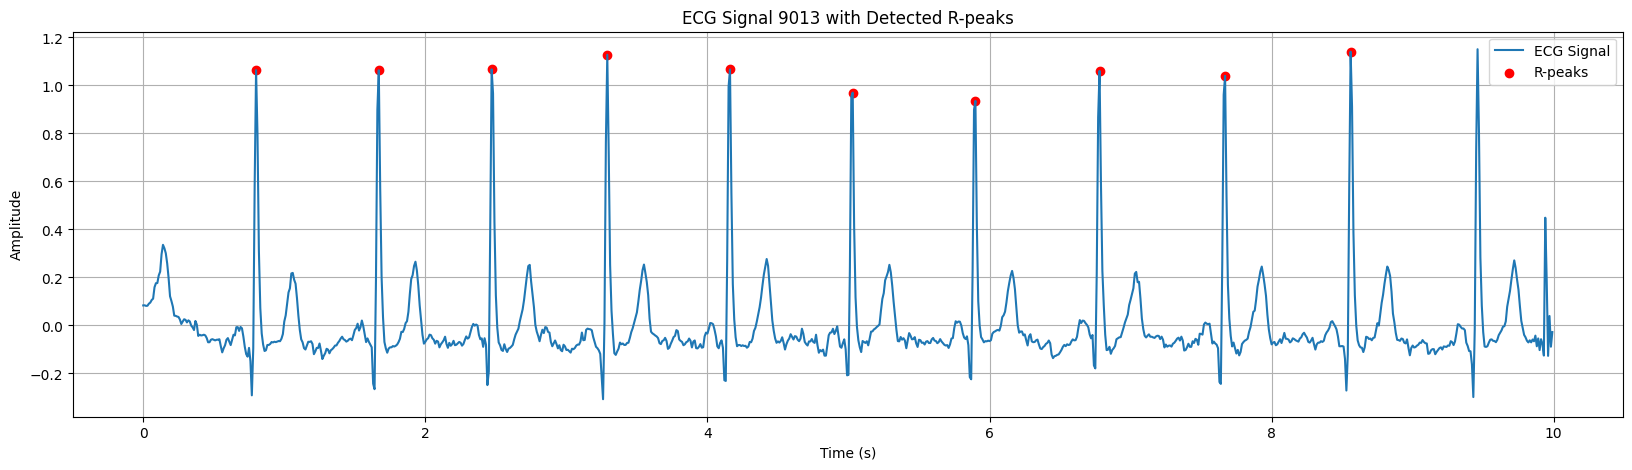

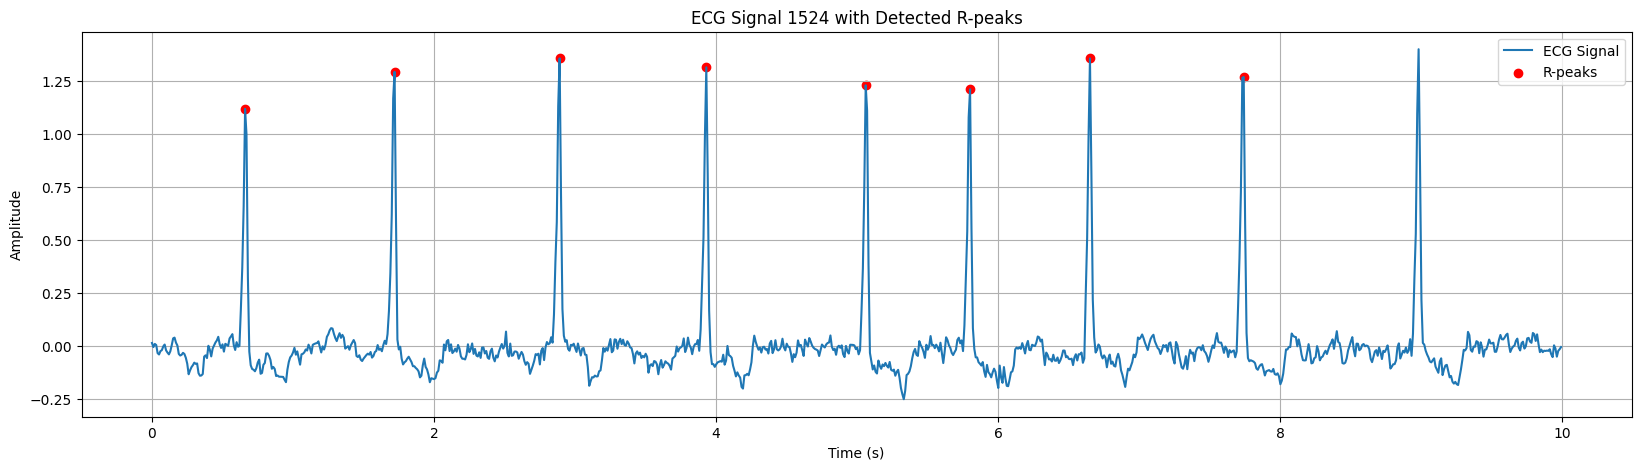

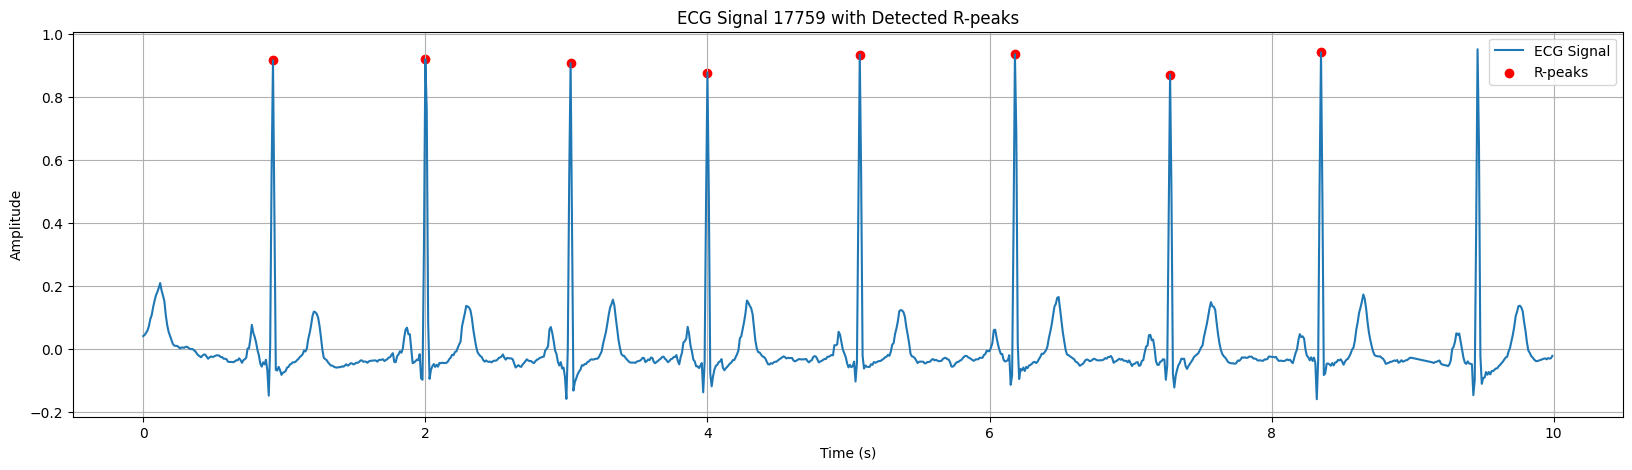

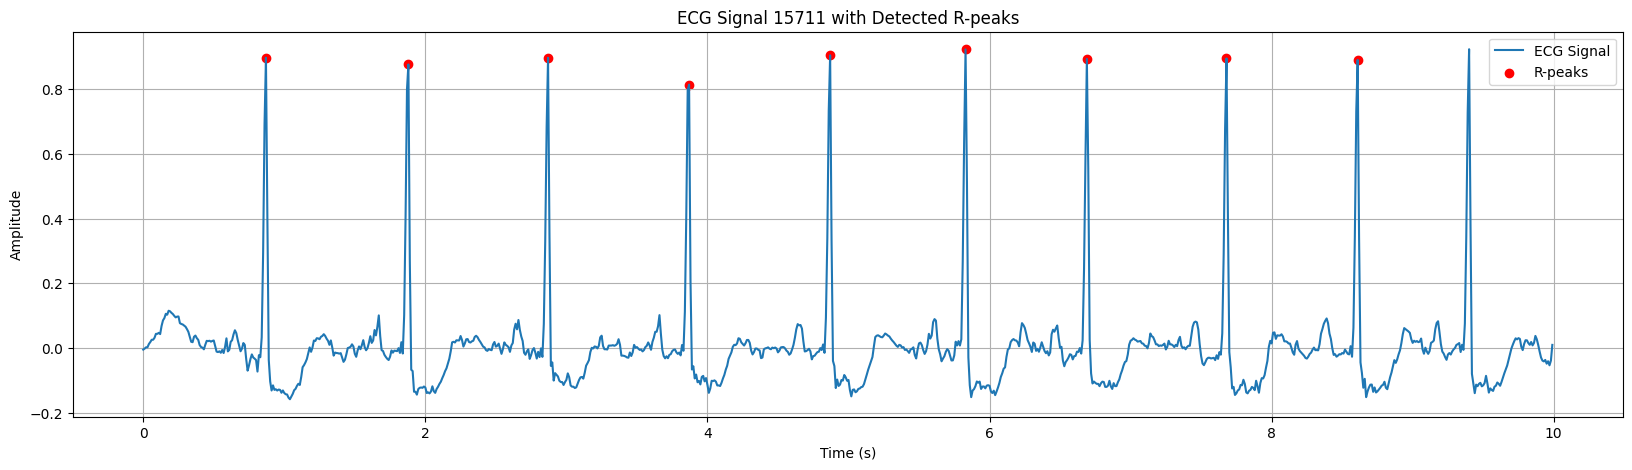

In [13]:
random_numbers = [random.randint(0, 21799) for i in range(20)]
sample_rate = 100
max_bpm = 200 


for index in random_numbers:
        
    ecg_signal = loaded_highpassedfiltered_signal[index][0][:]
    ## Stationary Wavelet Transform
    coeffs = pw.swt(ecg_signal, wavelet = "haar", level=2, start_level=0, axis=-1)
    d2 = coeffs[1][1] ##2nd level detail coefficients


    ## Threhold the detail coefficients
    avg = np.mean(d2)
    std = np.std(d2)
    sig_thres = [abs(i) if abs(i)>2.0*std else 0 for i in d2-avg]

    ## Find the maximum modulus in each window
    window = int((60.0/max_bpm)*sample_rate)
    sig_len = len(ecg_signal)
    n_windows = int(sig_len/window)
    modulus,qrs = [],[]

    ##Loop through windows and find max modulus
    for i in range(n_windows):
        start = i*window
        end = min([(i+1)*window,sig_len])
        mx = max(sig_thres[start:end])
        if mx>0:
            modulus.append( (start + np.argmax(sig_thres[start:end]),mx))


    ## Merge if within max bpm
    merge_width = int((0.2)*sample_rate)
    i=0
    while i < len(modulus)-1:
        ann = modulus[i][0]
        if modulus[i+1][0]-modulus[i][0] < merge_width:
            if modulus[i+1][1]>modulus[i][1]: # Take larger modulus
                ann = modulus[i+1][0]
            i+=1
                
        qrs.append(ann)
        i+=1 
    ## Pin point exact qrs peak
    window_check = int(sample_rate/6)
    #signal_normed = np.absolute((signal-np.mean(signal))/(max(signal)-min(signal)))
    r_peaks = [0]*len(qrs)

    for i,loc in enumerate(qrs):
        start = max(0,loc-window_check)
        end = min(sig_len,loc+window_check)
        wdw = np.absolute(ecg_signal[start:end] - np.mean(ecg_signal[start:end]))
        pk = np.argmax(wdw)
        r_peaks[i] = start+pk


    time = np.arange(len(ecg_signal)) / sample_rate
    plt.figure(figsize=(20,5))
    plt.plot(time, ecg_signal, label='ECG Signal')
    plt.scatter(time[r_peaks], ecg_signal[r_peaks], c='r', marker='o', label='R-peaks')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'ECG Signal {index} with Detected R-peaks')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



# Define the filter kernel (in this case, a moving average filter)
window_size = 3
kernel = np.ones(window_size) / window_size

# Apply the filter to the data
y_filtered = np.convolve(filtered, kernel, mode='same')

# Plot the results
plt.plot(X[0].T[0][:], label='Original Signal')
plt.plot(y_filtered, label='Filtered Signal')
plt.legend()
plt.show()
